In [1]:
!pip install gif

# Logistic Regression Excercise 2

## Multi-class classification of MNIST using Logistic Regression

The multi-class scenario for logistic regression is quite similar to the binary case, except that the label $y$ is now an integer in {1, ...., K} where $K$ is the number of classes. In this excercise you will be provided with handwritten digit images. Write the code and compute the test accuracy by training a logistic regression based classifier in (i) one-vs-one, and (ii) one-vs-all setting.

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [3]:
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from utils import plot_decision_boundary, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, sigmoid, normalize
import math
import gif
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from utils.ipynb


In [4]:
# Let's initialize our weights using uniform distribution
def weight_init_uniform_dist(X, y):
  
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = np.shape(y)

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

In [5]:
np.random.seed(12)

# One hot encoding of our output label vector y
def one_hot(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size), a] = 1
    return b

# Loading dataset
digits = datasets.load_digits()

# One-hot encoding of target label, Y
Y = digits.target
# Y = one_hot(Y)

# Absorbing weight b of the hyperplane
X = digits.data
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

<Figure size 432x288 with 0 Axes>

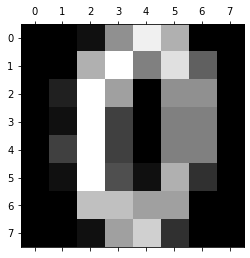

In [6]:
sns.reset_orig()

plt.gray()
plt.matshow(digits.images[10])
plt.show();

In [7]:
# Splitting dataset into train, val, and test set.
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, shuffle=True, test_size = 0.167)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.12517)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (1308, 65)
Validation dataset:  (188, 65)
Test dataset:  (301, 65)


In [8]:
# Normalizing X_train and absorbing weight b of the hyperplane
X_normalized_train = normalize(X_train[:, :64])

b_ones = np.ones((len(X_normalized_train), 1))
X_normalized_train = np.hstack((X_normalized_train, b_ones))

In [9]:
X_normalized_train.shape

(1308, 65)

# Write your code below

### Normalizing datasets
Normalise everything

In [11]:
def normalize_dataset(x):
  x = normalize(x[:, :64])
  b_ones = np.ones((len(x), 1))
  x = np.hstack((x, b_ones))
  return x

In [12]:
X_train = normalize_dataset(X_train)
X_test = normalize_dataset(X_test)
X_val = normalize_dataset(X_val)

## Weight Initialisation

initialize weights using uniform distribution and store it in initial_weights.

In [13]:
def weight_init_uniform_dist(X, y):
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    n_outputs = 1 #np.shape(y)[0]

    limit = 1 / math.sqrt(n_features)
    #print(n_features, n_outputs)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

In [14]:
initial_weights = weight_init_uniform_dist(X_train, Y_train)
initial_weights.shape

(65, 1)

## Train a model for binary classification

Uses batch gradient descent. Contains functions 

- `predict(x, w)` : Returns sigmoid of wTx
- `train_binary_classification(X_train, Y_train, base_weights, num_epochs, learning_rate)`: returns the trained weights after num_epochs, starting from the base_weights
- `accuracy_binary_classification(x, y, w)`: predicts all the samples and then returns the fraction of correctly classified samples

In [15]:
def predict(x, w):
  wtx = np.dot(x, w)
  y = sigmoid(wtx)
  return y

In [16]:
def train_binary_classification(X_train, Y_train, base_weights, num_epochs, learning_rate):
    weights = base_weights #.copy() # hakkke
    n_samples = X_train.shape[0]
    for epoch in range(1, num_epochs+1):
        prev_weights = weights
        y_pred = predict(X_train, weights).reshape(-1,1)
        gradient = 1 * np.dot(X_train.T, (Y_train.reshape(-1,1) - y_pred))
        weights += (learning_rate/n_samples) * gradient
        if ( (gradient<10**-6).all() ):
          print(".",end="")
          break
        weights = np.round(weights, decimals=7) # why tho?
        epoch += 1
    
    acc = accuracy_binary_classification(X_train, Y_train, weights)
    if(acc<0.8): print(acc,"ISSUE")

    return weights

In [17]:
def accuracy_binary_classification(x, y, w):
  y_pred = np.array(predict(x, w) > 0.5).reshape(-1,1)
  y_actual = y.reshape(-1,1)
  return np.mean(y_actual == y_pred)

## One vs All classfier

### Relabel the classes for one vs all

- 1 => it is the class
- 0 => it is not the class


In [18]:
def make_ova_data(x, y, k):  # k is the class
  # one-vs-all binary classifier: assign k as 1 and not k as 0
  ova_y = np.where(y == k, 1, 0)
  ova_x = x
  # print(ova_x.shape,ova_y.shape)
  return ova_x, ova_y

### Train

In [19]:
def train_one_vs_all(X_train, Y_train, base_weights, num_epochs, learning_rate):
    final_weights = base_weights
    classes = np.unique(Y_train) # contains all classes present
    mi = 0  # model number
    # Training using Batch GD
    for k_ind in range(len(classes)):
      k = classes[k_ind]
      # make the training data
      ova_x, ova_y = make_ova_data(X_train, Y_train, k)
      # train
      trained_weight = train_binary_classification(ova_x, ova_y, base_weights[mi], num_epochs, learning_rate)
      # Display details, with graph
      acc = accuracy_binary_classification(ova_x, ova_y, trained_weight)
      print("One-vs-all classifier for class ", k, ":", acc)
      # Add to list
      final_weights[mi] = trained_weight.copy()
      mi += 1
    print("Training complete")
    #print(final_weights.shape)
    return final_weights

### Predict

In [20]:
def predict_one_vs_all(x, y, ws):
    mi = 0  # model number
    classes = np.unique(y)  # get all classes
    # point scores as per the model says
    points = np.zeros((len(classes), (x.shape)[0]))
    # print(x.shape,y.shape,points.shape)
    for k_ind in range(len(classes)):
        k = classes[k_ind]
        # print(ws.shape)
        w = ws[mi]
        # print(w.shape,x.shape)
        y_pred = predict(x, w).flatten() #.flatten()
        # print(y_pred.shape, points[k_ind].shape)
        # update scores
        points[k_ind] += y_pred
        mi += 1
    # for each point find the max valued class
    final_y_pred = np.argmax(points, axis=0)
    return final_y_pred

### Calculate accuracy

In [21]:
def accuracy_one_vs_all(x, y, ws):
    y_pred = predict_one_vs_all(x, y, ws).flatten()
    y_actual = y.flatten()
    return np.mean(y_actual == y_pred)

## Calling all the functions for a one-vs-all session

In [22]:
base_weights = np.array([initial_weights]*10)
#base_weights=np.zeros((10,65,1))
base_weights.shape

(10, 65, 1)

In [23]:
trained_weights = train_one_vs_all(X_train, Y_train, base_weights, num_epochs=100000, learning_rate=1.0)

.One-vs-all classifier for class  0 : 0.9021406727828746
One-vs-all classifier for class  1 : 0.9900611620795107
One-vs-all classifier for class  2 : 1.0
.One-vs-all classifier for class  3 : 0.9051987767584098
One-vs-all classifier for class  4 : 0.9992354740061162
.One-vs-all classifier for class  5 : 0.8975535168195719
One-vs-all classifier for class  6 : 1.0
One-vs-all classifier for class  7 : 0.9977064220183486
.One-vs-all classifier for class  8 : 0.9036697247706422
.One-vs-all classifier for class  9 : 0.8937308868501529
Training complete


In [24]:
print(trained_weights.shape)
print(X_train.shape)

(10, 65, 1)
(1308, 65)


In [25]:
print("Training set:\tAccuracy: ", accuracy_one_vs_all(X_train, Y_train, trained_weights))
print("Validation set:\tAccuracy: ", accuracy_one_vs_all(X_val, Y_val, trained_weights))
print("Test set:\tAccuracy: ", accuracy_one_vs_all(X_test, Y_test, trained_weights))

Training set:	Accuracy:  0.75
Validation set:	Accuracy:  0.6914893617021277
Test set:	Accuracy:  0.6810631229235881


In [26]:
base_weights = np.array([initial_weights]*10)
acc=[]
for e in range(5000,10000,100):
  print("\nepoch",e)
  trained_weights = train_one_vs_all(X_train, Y_train, base_weights, num_epochs=e, learning_rate=0.1)
  acc+=[[accuracy_one_vs_all(X_train, Y_train, trained_weights),accuracy_one_vs_all(X_val, Y_val, trained_weights),accuracy_one_vs_all(X_test, Y_test, trained_weights)]]


epoch 5000
.One-vs-all classifier for class  0 : 0.8715596330275229
One-vs-all classifier for class  1 : 0.9434250764525994
One-vs-all classifier for class  2 : 0.9640672782874617
.One-vs-all classifier for class  3 : 0.886085626911315
One-vs-all classifier for class  4 : 0.9831804281345565
.One-vs-all classifier for class  5 : 0.8662079510703364
One-vs-all classifier for class  6 : 0.9847094801223242
One-vs-all classifier for class  7 : 0.9732415902140673
.One-vs-all classifier for class  8 : 0.8746177370030581
.One-vs-all classifier for class  9 : 0.8646788990825688
Training complete

epoch 5100
.One-vs-all classifier for class  0 : 0.9021406727828746
One-vs-all classifier for class  1 : 0.959480122324159
One-vs-all classifier for class  2 : 0.9801223241590215
.One-vs-all classifier for class  3 : 0.9051987767584098
One-vs-all classifier for class  4 : 0.9908256880733946
.One-vs-all classifier for class  5 : 0.8975535168195719
One-vs-all classifier for class  6 : 0.9892966360856269


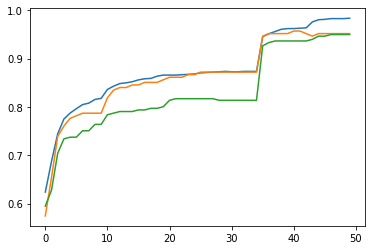

In [27]:
plt.plot(acc)
one_vs_all_acc = acc[len(acc)-1]

## One vs One Classifier

### Relabel classes for one-vs-one

- 0 => First class k1
- 1 => Second class k2

In [28]:
def make_pairwise_data(x, y, k1, k2):  # k1 and k2 are the two classes
  # Identify those y_train indices correcsponding to the given classes
  binary_y_indices = np.argwhere((y == k1, y == k2)).T[1]
  binary_x = x[binary_y_indices]
  binary_y = y[binary_y_indices]
  # one-vs-one binary classifier: assign k1 as 0 and k2 as 1
  binary_y = np.where(binary_y == k1, 0, 1)
  # print(binary_x.shape,binary_y.shape, binary_y_indices.shape)
  return binary_x, binary_y

### Train

In [29]:
def train_one_vs_one(X_train, Y_train, base_weights, num_epochs, learning_rate):
    final_weights = base_weights
    classes = np.unique(Y_train) # contains all classes present
    mi = 0  # model number
    # Training using Batch GD
    for k1_ind in range(len(classes)):
        for k2_ind in range(k1_ind):
            k1 = classes[k1_ind]
            k2 = classes[k2_ind]
            # make the training data
            binary_x, binary_y = make_pairwise_data(X_train, Y_train, k1, k2)
            # train
            trained_weight = train_binary_classification(binary_x, binary_y, base_weights[mi], num_epochs, learning_rate)
            # Display details, with graph
            acc = accuracy_binary_classification(binary_x, binary_y, trained_weight)
            print("One-vs-one classifier for classes: ", k1, "vs", k2, ":", acc)
            # Add to list
            final_weights[mi] = trained_weight.copy()
            mi += 1
    print("Training complete")
    return final_weights

### Predict

In [30]:
def predict_one_vs_one(x, y, ws):
    # Each model (0,1,2) corresponds to the classifications (1,0),(2,0),(2,1)
    mi = 0  # model number
    classes = np.unique(y)  # get all classes
    # point as per the model says
    points = np.zeros((len(classes), (x.shape)[0]))
    for k1_ind in range(len(classes)):
        for k2_ind in range(k1_ind):
            k1 = classes[k1_ind]
            k2 = classes[k2_ind]
            # print(ws.shape)
            w = ws[mi]
            y_pred = predict(x, w).flatten()
            #print(y_pred.shape, points[k1_ind].shape)
            y_pred_k1 = np.array(1-y_pred)
            y_pred_k2 = np.array(y_pred)
            # update scores
            points[k1_ind] += y_pred_k1
            points[k2_ind] += y_pred_k2
            mi += 1
    # for each point find the majority voted class
    final_y_pred = np.argmax(points, axis=0)
    return final_y_pred

### Calculate accuracy

In [31]:
def accuracy_one_vs_one(x, y, ws):
    y_pred = predict_one_vs_one(x, y, ws).flatten()
    y_actual = y.flatten()
    return np.mean(y_actual == y_pred)

## Calling all the functions for one vs one session

In [32]:
base_weights_ovo = np.array([initial_weights]*45)
#base_weights=np.zeros((45,65,1))
base_weights_ovo.shape

(45, 65, 1)

In [33]:
trained_weights = train_one_vs_one(X_train, Y_train, base_weights_ovo, num_epochs=1000, learning_rate=1)

One-vs-one classifier for classes:  1 vs 0 : 1.0
One-vs-one classifier for classes:  2 vs 0 : 1.0
One-vs-one classifier for classes:  2 vs 1 : 1.0
One-vs-one classifier for classes:  3 vs 0 : 1.0
One-vs-one classifier for classes:  3 vs 1 : 1.0
One-vs-one classifier for classes:  3 vs 2 : 0.9960629921259843
One-vs-one classifier for classes:  4 vs 0 : 0.9962121212121212
One-vs-one classifier for classes:  4 vs 1 : 0.9925650557620818
One-vs-one classifier for classes:  4 vs 2 : 1.0
One-vs-one classifier for classes:  4 vs 3 : 1.0
One-vs-one classifier for classes:  5 vs 0 : 1.0
One-vs-one classifier for classes:  5 vs 1 : 1.0
One-vs-one classifier for classes:  5 vs 2 : 1.0
One-vs-one classifier for classes:  5 vs 3 : 1.0
One-vs-one classifier for classes:  5 vs 4 : 0.9925925925925926
One-vs-one classifier for classes:  6 vs 0 : 1.0
One-vs-one classifier for classes:  6 vs 1 : 0.9962546816479401
One-vs-one classifier for classes:  6 vs 2 : 1.0
One-vs-one classifier for classes:  6 vs 3 

In [34]:
print(trained_weights.shape)
print(X_train.shape)

(45, 65, 1)
(1308, 65)


In [35]:
print("Training set:\tAccuracy: ", accuracy_one_vs_one(X_train, Y_train, trained_weights))
print("Validation set:\tAccuracy: ", accuracy_one_vs_one(X_val, Y_val, trained_weights))
print("Test set:\tAccuracy: ", accuracy_one_vs_one(X_test, Y_test, trained_weights))

Training set:	Accuracy:  0.9717125382262997
Validation set:	Accuracy:  0.9468085106382979
Test set:	Accuracy:  0.9568106312292359


In [36]:
base_weights = np.array([initial_weights]*45)
acc=[]
for e in range(8000,10000,100):
  print("\nEpoch",e)
  trained_weights = train_one_vs_one(X_train, Y_train, base_weights, num_epochs=e, learning_rate=0.1)
  acc+=[[accuracy_one_vs_one(X_train, Y_train, trained_weights),accuracy_one_vs_one(X_val, Y_val, trained_weights),accuracy_one_vs_one(X_test, Y_test, trained_weights)]]


Epoch 8000
One-vs-one classifier for classes:  1 vs 0 : 1.0
One-vs-one classifier for classes:  2 vs 0 : 1.0
One-vs-one classifier for classes:  2 vs 1 : 1.0
One-vs-one classifier for classes:  3 vs 0 : 1.0
One-vs-one classifier for classes:  3 vs 1 : 1.0
One-vs-one classifier for classes:  3 vs 2 : 0.9960629921259843
One-vs-one classifier for classes:  4 vs 0 : 0.9962121212121212
One-vs-one classifier for classes:  4 vs 1 : 0.9925650557620818
One-vs-one classifier for classes:  4 vs 2 : 0.9962406015037594
One-vs-one classifier for classes:  4 vs 3 : 1.0
One-vs-one classifier for classes:  5 vs 0 : 1.0
One-vs-one classifier for classes:  5 vs 1 : 1.0
One-vs-one classifier for classes:  5 vs 2 : 1.0
One-vs-one classifier for classes:  5 vs 3 : 0.9922480620155039
One-vs-one classifier for classes:  5 vs 4 : 0.9925925925925926
One-vs-one classifier for classes:  6 vs 0 : 1.0
One-vs-one classifier for classes:  6 vs 1 : 0.9962546816479401
One-vs-one classifier for classes:  6 vs 2 : 1.0
O

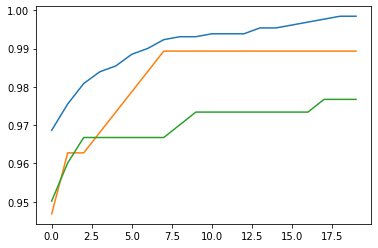

In [37]:
plt.plot(acc)
one_vs_one_acc = acc[len(acc)-1]

# COMPARISON OF THE ACCURACY

In [39]:
one_vs_one_acc

[0.9984709480122325, 0.9893617021276596, 0.9767441860465116]

In [40]:
one_vs_all_acc

[0.9839449541284404, 0.9521276595744681, 0.9501661129568106]

From the above two accuracies we can see that one vs one model provides a better accuracy compared to one-vs-all model on the test set.

- One-vs-one test accuracy: 0.9767441860465116
- One-vs-all test accuracy: 0.9501661129568106
